<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment4/MINST_classifier_with_basic_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import math
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import np_utils
import sys
np.random.seed(1)

## Data Importing

In [ ]:
def data_prep(x_train, y_train, x_test, y_test):
  #images, labels = (x_train[0:10000].reshape(10000, 28*28)/ 255, y_train[0:10000])
  images, labels = (x_train.reshape(len(x_train), 28*28)/ 255, y_train)
  one_hot_labels = np.zeros((len(labels), 10))
  for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
  labels = one_hot_labels
  test_images = x_test.reshape(len(x_test), 28*28)/255
  test_labels = np.zeros((len(y_test), 10))
  for i, l in enumerate(y_test):
    test_labels[i][l] = 1
  return (images, labels, test_images, test_labels)

In [ ]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
images, labels, test_images, test_labels = data_prep(x_train, y_train, x_test, y_test)
np.random.seed(1)

## Previewing the data

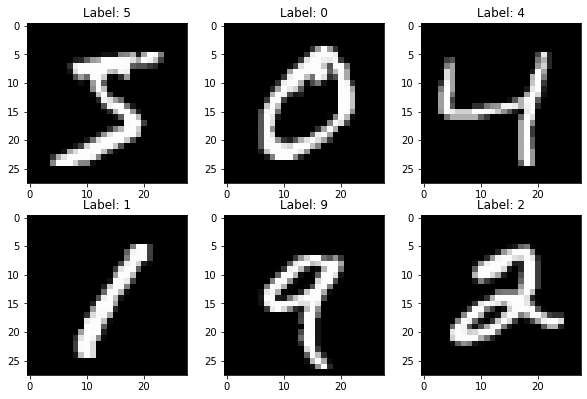

In [ ]:
plt.figure(figsize=[10,10])
for i in range(6):
  plt.subplot(3,3,i+1)
  plt.title("Label: %i"%y_train[i])
  plt.imshow(x_train[i].reshape([28,28]),cmap='gray')

## Sampling the data for processing

In [ ]:
x_train = x_train[:20000]
y_train = y_train[:20000]
x_test = x_test[:1000]
y_test = y_test[:1000]

## Activation function ReLU and Softmax

In [ ]:
relu = lambda x: (x>=0) * x
relu2derive = lambda x: x>=0
def softmax(x):
  temp = np.exp(x)
  return temp/np.sum(temp, axis=1, keepdims=True)

## Building the Basic Neural Network

In [ ]:
#Class Neural Network:
class NNetwork:
  def __init__(self, images, batch_size, alpha, iterations, layers, labels,drop_out):
    self.images = images
    self.batch_size = batch_size
    self.alpha = alpha
    self.iterations = iterations
    self.layers = layers
    self.labels = labels
    self.drop_out = drop_out

#Weights Initialization:    
  def ini_weights(self):
    weights = [None] * (len(self.layers)-1)
    a = [0.204, 0.215, 0.22, 0.328]
    for i in range(len(self.layers)-1):
      weights[i] = a[i] * np.random.random((self.layers[i], self.layers[i+1])) -0.1
    return weights

#Activation Function:
  def activation(self,l, w,d):
    layer = np.dot(l,w)
    relu(layer)
    if(self.drop_out == True and d==0):
      dropout_mask = np.random.randint(2, size = layer.shape)
      layer *= dropout_mask * 2
    return layer
    
#Forward propogation function: 
  def forward_prop(self, layer_in, weights):
    ec_layer = []
    next_layer = [None] * (len(self.layers)-2)
    
    ec_layer.append(layer_in)
    for i in range(len(self.layers)-2):
      d = i
      next_layer[i] = self.activation(ec_layer[i], weights[i], d)
      ec_layer.append(next_layer[i])
    layer_out = softmax(np.dot(ec_layer[-1], weights[-1]))
    ec_layer.append(layer_out)
    return ec_layer

#Backpropogation function:
  def back_prop(self, each_layer, batch_start, batch_end, weights):
    grad = []
    delta = [None] * (len(self.layers)-2)
    op_delta = (self.labels[batch_start:batch_end] - each_layer[-1])/self.batch_size
    temp = op_delta
    for i in range(1,len(each_layer)-1):
      delta[-i] = op_delta.dot(weights[-i].T) * relu2derive(each_layer[-i-1])
      op_delta = delta[-i]
    
    for j in range(len(delta)):
      grad.append(delta[j])
    grad.append(temp)
    return grad
  
#Weight updation:
  def weights_up(self, gradients, each_layer,weights, alpha):
    for i in range(len(weights)):
      weights[i] = weights[i] + self.alpha*np.dot(each_layer[i].T, gradients[i])
    return weights

#Image augmentation:
  def imageAug(self, images):
  
    images = images.reshape(-1,28,28,1)
    datagen = ImageDataGenerator(
              rotation_range=10,  
              zoom_range = 0.50,  
              width_shift_range=0.1, 
              height_shift_range=0.1)


    datagen.fit(images)
    batches = datagen.flow(images, batch_size = len(images))
    x_batch = next(batches)
    x_batch = x_batch.reshape(len(images), 28*28)
    return x_batch

  def data_augmentation(x_train,y_train,augment_size=5000): 
        image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last",
            zca_whitening=True)
        image_generator.fit(x_train, augment=True)       
        train_size=len(x_train)
        randidx = np.random.randint(train_size, size=augment_size)
        x_augmented = x_train[randidx].copy()
        y_augmented = y_train[randidx].copy()
        x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                    batch_size=augment_size, shuffle=False).next()[0]        
        x_train = np.concatenate((x_train, x_augmented))
        y_train = np.concatenate((y_train, y_augmented))
        train_size = x_train.shape[0]
        return x_train, y_train
  
#Confusion Matrix plot:
  def plot_confusion_matrix(self, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

 #Training the data with loss function and batch sizes:     
  def train_net(self,weights):
    alpha = self.alpha
    train_loss, train_acc = (0.0, 0)
    aug_images = self.images
    for i in range(int(len(aug_images)/self.batch_size)):
      batch_start, batch_end = (i*self.batch_size, (i+1)*self.batch_size)
      layer_in = aug_images[batch_start:batch_end]
      each_layer = self.forward_prop(layer_in, weights)
      train_loss += np.sum((each_layer[-1] - self.labels[batch_start:batch_end]) **2)
      for k in range(self.batch_size):
        train_acc += int(np.argmax(each_layer[-1][k:k+1]) == np.argmax(self.labels[batch_start+k:batch_start+k+1]))

        gradients = self.back_prop(each_layer, batch_start, batch_end, weights)
        weights = self.weights_up(gradients,each_layer, weights, alpha)
    
    alpha = alpha + 0.000005
    
    # if(acc>temp):
    #   temp = acc
    #   g_weights = weights
    return (train_loss, train_acc, weights)

#Predict model:
  def nn_fit(self,test_images, test_labels):
    images = self.images
    print(images.shape)
    weights = self.ini_weights()
    tr_loss = []
    tes_loss = []
    for j in range(self.iterations):
      y_pred = []
      test_error, test_cnt = (0.0, 0)
      train_loss,train_acc,weights = self.train_net(weights)

      for i in range(len(test_images)):
        layer_in = test_images[i:i+1]
        each_layer = self.forward_prop(layer_in, weights)
        y = each_layer[-1]
        y_pred.append(y)

        test_error += np.sum((test_labels[i:i+1] - each_layer[-1]) **2)
        test_cnt += int(np.argmax(each_layer[-1]) == np.argmax(test_labels[i:i+1]))

      tr_loss.append(train_loss/float(len(images)))
      tes_loss.append(test_error/float(len(test_images)))  
      print("Epoch",str(j)," train_loss:" + str(train_loss/float(len(images)))[0:5], \
            "Train accuracy:",format((train_acc/float(len(images))),'.4f'),\
            "Validation_loss:" + str(test_error/float(len(test_images)))[0:5], \
            "Val accuracy:",format((test_cnt/float(len(test_images))), '.4f'))
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1000,10)
    return y_pred, tr_loss, tes_loss

#Plot the graph
  def plot_validation(self, tr_loss, tes_loss):
    epoch_count = range(1, len(tr_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, tr_loss, 'r--')
    plt.plot(epoch_count, tes_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

#plot the missed predictions
  def display_errors(self,errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("\nPredicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

In [ ]:
images, labels, test_images, test_labels = data_prep(x_train, y_train, x_test, y_test)

## Initializing the hidden layers

In [ ]:
image_pixel, num_labels = (784,10)
hidden_layers = [256,128,64]
layer_size = [image_pixel]
for i in range(len(hidden_layers)):
  layer_size.append(hidden_layers[i])
layer_size.append(num_labels)

In [ ]:
print(layer_size)

[784, 256, 128, 64, 10]


## Model execution with mini batch, learning rate and drop out 

(20000, 784)
Epoch 0  train_loss:0.637 Train accuracy: 0.5304 Validation_loss:0.438 Val accuracy: 0.6860
Epoch 1  train_loss:0.337 Train accuracy: 0.7701 Validation_loss:0.339 Val accuracy: 0.7680
Epoch 2  train_loss:0.281 Train accuracy: 0.8056 Validation_loss:0.305 Val accuracy: 0.7980
Epoch 3  train_loss:0.258 Train accuracy: 0.8227 Validation_loss:0.346 Val accuracy: 0.7650
Epoch 4  train_loss:0.243 Train accuracy: 0.8342 Validation_loss:0.288 Val accuracy: 0.8050
Epoch 5  train_loss:0.231 Train accuracy: 0.8417 Validation_loss:0.327 Val accuracy: 0.7720
Epoch 6  train_loss:0.220 Train accuracy: 0.8490 Validation_loss:0.261 Val accuracy: 0.8250
Epoch 7  train_loss:0.221 Train accuracy: 0.8498 Validation_loss:0.274 Val accuracy: 0.8210
Epoch 8  train_loss:0.211 Train accuracy: 0.8579 Validation_loss:0.306 Val accuracy: 0.7950
Epoch 9  train_loss:0.211 Train accuracy: 0.8569 Validation_loss:0.267 Val accuracy: 0.8160


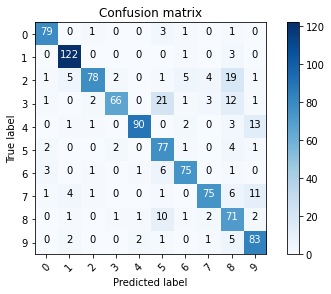

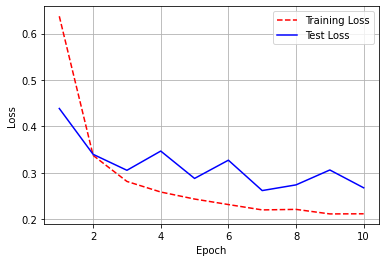

In [ ]:
#Initialize Model:
model = NNetwork(images=images, batch_size=100, alpha = 0.000224, iterations=10, layers=layer_size, labels=labels, drop_out=True )
y_pred, tr_loss, tes_loss = model.nn_fit(test_images, test_labels)

Y_pred_classes = np.argmax(y_pred,axis =1) 
Y_true = np.argmax(test_labels,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
model.plot_confusion_matrix(confusion_mtx, classes = range(10))
model.plot_validation(tr_loss, tes_loss)

## Common errors

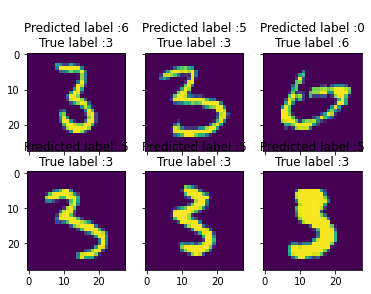

In [ ]:
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = test_images[errors]

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
model.display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Augmenting the data

In [ ]:
xtrain_augmented = x_train
ytrain_augmented = y_train

xtrain_augmented = xtrain_augmented.reshape(-1,28,28,1)

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False) 
datagen.fit(xtrain_augmented)

In [ ]:
def data_augmentation(x_train,y_train,augment_size=20000): 
        image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last",
            zca_whitening=True)
        image_generator.fit(x_train, augment=True)       
        train_size=len(x_train)
        randidx = np.random.randint(train_size, size=augment_size)
        x_augmented = x_train[randidx].copy()
        y_augmented = y_train[randidx].copy()
        x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                    batch_size=augment_size, shuffle=False).next()[0]        
        x_train = np.concatenate((x_train, x_augmented))
        y_train = np.concatenate((y_train, y_augmented))
        train_size = x_train.shape[0]
        return x_train, y_train

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 28, 28,1))
x_train,y_train=data_augmentation(x_train,y_train)

images, labels, test_images, test_labels = data_prep(x_train, y_train, x_test, y_test)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


## Model Execution with augmented data

(45000, 784)
Epoch 0  train_loss:0.782 Train accuracy: 0.3948 Validation_loss:0.415 Val accuracy: 0.7200
Epoch 1  train_loss:0.644 Train accuracy: 0.5321 Validation_loss:0.338 Val accuracy: 0.7600
Epoch 2  train_loss:0.620 Train accuracy: 0.5630 Validation_loss:0.285 Val accuracy: 0.8040
Epoch 3  train_loss:0.611 Train accuracy: 0.5773 Validation_loss:0.338 Val accuracy: 0.7800
Epoch 4  train_loss:0.603 Train accuracy: 0.5912 Validation_loss:0.247 Val accuracy: 0.8350
Epoch 5  train_loss:0.600 Train accuracy: 0.5966 Validation_loss:0.278 Val accuracy: 0.8160
Epoch 6  train_loss:0.596 Train accuracy: 0.6025 Validation_loss:0.273 Val accuracy: 0.8090
Epoch 7  train_loss:0.593 Train accuracy: 0.6092 Validation_loss:0.246 Val accuracy: 0.8330
Epoch 8  train_loss:0.590 Train accuracy: 0.6113 Validation_loss:0.279 Val accuracy: 0.8190
Epoch 9  train_loss:0.590 Train accuracy: 0.6136 Validation_loss:0.236 Val accuracy: 0.8430


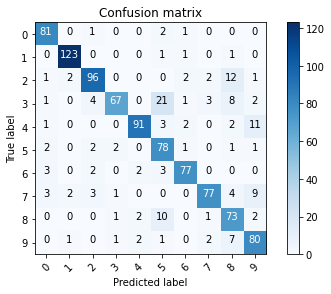

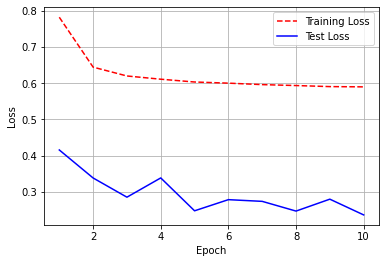

In [ ]:
#Initialize Model:
model = NNetwork(images=images, batch_size=100, alpha = 0.000224, iterations=10, layers=layer_size, labels=labels, drop_out=True )
y_pred, tr_loss, tes_loss = model.nn_fit(test_images, test_labels)

Y_pred_classes = np.argmax(y_pred,axis =1) 
Y_true = np.argmax(test_labels,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
model.plot_confusion_matrix(confusion_mtx, classes = range(10))
model.plot_validation(tr_loss, tes_loss)

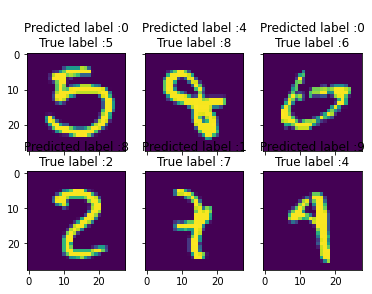

In [ ]:
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = test_images[errors]

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
model.display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)